In [3]:
from data_loader import load 

import numpy as np
import matplotlib.pyplot as plt 
plt.style.use('dark_background')
import seaborn as sns
import pandas as pd 
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [7]:
cigar = load('smoking.csv').drop(columns=["lnincome","beer", "age15to24"])
cigar

,state,year,cigsale,retprice,california,after_treatment
0,1,1970,89.800003,39.599998,False,False
1,1,1971,95.400002,42.700001,False,False
2,1,1972,101.099998,42.299999,False,False
3,1,1973,102.900002,42.099998,False,False
4,1,1974,108.199997,43.099998,False,False
...,...,...,...,...,...,...
1204,39,1996,110.300003,162.500000,False,True
1205,39,1997,108.800003,164.100006,False,True
1206,39,1998,102.900002,168.800003,False,True
1207,39,1999,104.800003,189.600006,False,True


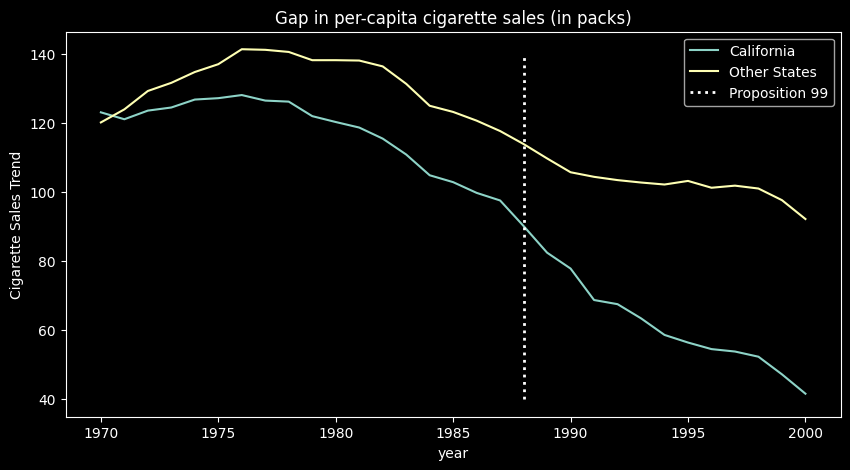

In [9]:
ax = plt.subplot(1, 1, 1)

(cigar
 .assign(california = np.where(cigar["california"], "California", "Other States"))
 .groupby(["year", "california"])
 ["cigsale"]
 .mean()
 .reset_index()
 .pivot(index="year", columns="california", values="cigsale")
 .plot(ax=ax, figsize=(10,5)))


plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Cigarette Sales Trend")
plt.title("Gap in per-capita cigarette sales (in packs)")
plt.legend();  

Finding the weight with OLS. Synthetic control is a weighted combination of other units. scaling import ant for features 

In [10]:
features = ["cigsale", "retprice"]

inverted = (cigar.query("~after_treatment") # filter pre-intervention period
            .pivot(index='state', columns="year")[features] # make one column per year and one row per state
            .T) # flip the table to have one column per state

inverted.head()

state                 1           2           3           4           5   \
        year                                                               
cigsale 1970   89.800003  100.300003  123.000000  124.800003  120.000000   
        1971   95.400002  104.099998  121.000000  125.500000  117.599998   
        1972  101.099998  103.900002  123.500000  134.300003  110.800003   
        1973  102.900002  108.000000  124.400002  137.899994  109.300003   
        1974  108.199997  109.699997  126.699997  132.800003  112.400002   

state                 6           7           8           9           10  ...  \
        year                                                              ...   
cigsale 1970  155.000000  109.900002  102.400002  124.800003  134.600006  ...   
        1971  161.100006  115.699997  108.500000  125.599998  139.300003  ...   
        1972  156.300003  117.000000  126.099998  126.599998  149.199997  ...   
        1973  154.699997  119.800003  121.800003  124.400002  156.000000  ...   
        1974  151.300003  123.699997  125.599998  131.899994  159.600006  ...   

state                 30          31          32          33         34  \
        year                                                              
cigsale 1970  103.599998   92.699997   99.800003  106.400002  65.500000   
        1971  115.000000   96.699997  106.300003  108.900002  67.699997   
        1972  118.699997  103.000000  111.500000  108.599998  71.300003   
        1973  125.500000  103.500000  109.699997  110.400002  72.699997   
        1974  129.699997  108.400002  114.800003  114.699997  75.599998   

state                 35          36          37          38          39  
        year                                                              
cigsale 1970  122.599998  124.300003  114.500000  106.400002  132.199997  
        1971  124.400002  128.399994  111.500000  105.400002  131.699997  
        1972  138.000000  137.000000  117.500000  108.800003  140.000000  
        1973  146.800003  143.100006  116.599998  109.500000  141.199997  
        1974  151.800003  149.600006  119.900002  111.800003  145.800003  

[5 rows x 39 columns]

In [22]:
y = inverted[3].values # state of california
X = inverted.drop(columns=3).values  # other states

In [23]:
from sklearn.linear_model import LinearRegression
weights_lr = LinearRegression(fit_intercept=False).fit(X, y).coef_
weights_lr.round(3)

array([-0.436, -1.038,  0.679,  0.078,  0.339,  1.213,  0.143,  0.555,
       -0.295,  0.052, -0.529,  1.235, -0.549,  0.437, -0.023, -0.266,
       -0.25 , -0.667, -0.106, -0.145,  0.109,  0.242, -0.328,  0.594,
        0.243, -0.171, -0.02 ,  0.14 , -0.811,  0.362,  0.519, -0.304,
        0.805, -0.318, -1.246,  0.773, -0.055, -0.032])

In [24]:
calif_synth_lr = (cigar.query("~california")
                  .pivot(index='year', columns="state")["cigsale"]
                  .values.dot(weights_lr))

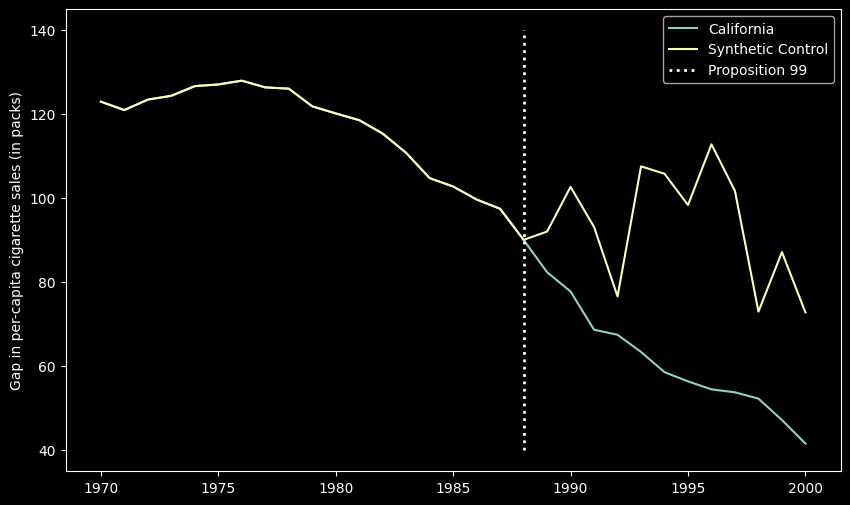

In [25]:
plt.figure(figsize=(10,6))
plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"], label="California")
plt.plot(cigar.query("california")["year"], calif_synth_lr, label="Synthetic Control")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.legend();

- overfit, could use lasso or ridge here.
- alternatively we can prevent extrapolation to only interpolate using convex combinations

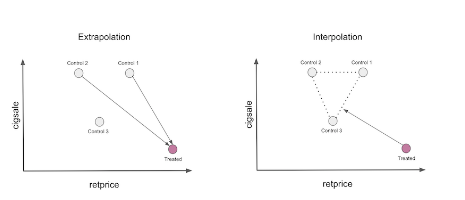

In [26]:
from typing import List
from operator import add
from toolz import reduce, partial

def loss_w(W, X, y) -> float:
    return np.sqrt(np.mean((y - X.dot(W))**2))

In [27]:
lambda x: np.sum(x) - 1

<function __main__.<lambda>(x)>

In [28]:
from scipy.optimize import fmin_slsqp

def get_w(X, y):
    
    w_start = [1/X.shape[1]]*X.shape[1]

    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
    return weights

In [29]:
calif_weights = get_w(X, y)
print("Sum:", calif_weights.sum())
np.round(calif_weights, 4)

Sum: 1.0000000000007276


array([0.    , 0.    , 0.    , 0.0852, 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.113 , 0.1051, 0.4566, 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.2401, 0.    , 0.    , 0.    , 0.    , 0.    ])

In [30]:
calif_synth = cigar.query("~california").pivot(index='year', columns="state")["cigsale"].values.dot(calif_weights)

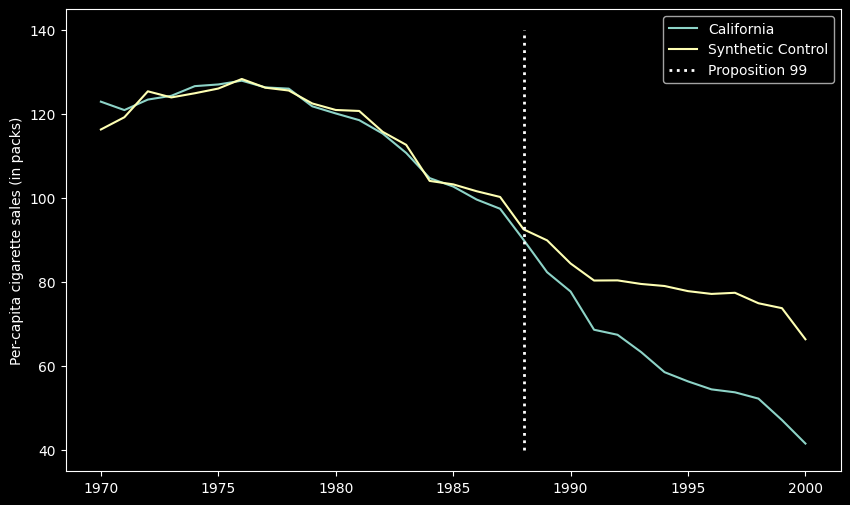

In [31]:
plt.figure(figsize=(10,6))
plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"], label="California")
plt.plot(cigar.query("california")["year"], calif_synth, label="Synthetic Control")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Per-capita cigarette sales (in packs)")
plt.legend();

Now effect over time can easily be estimated as treated - synthetic control:

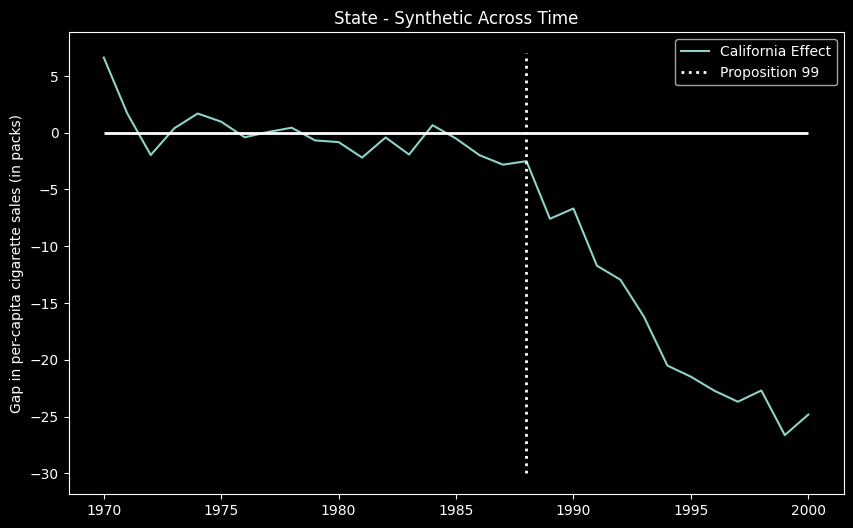

In [32]:
plt.figure(figsize=(10,6))
plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"] - calif_synth,
         label="California Effect")
plt.vlines(x=1988, ymin=-30, ymax=7, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=2)
plt.title("State - Synthetic Across Time")
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.legend();

To get statistical signfincane:
1. use idea of fisher's exact test
2. exhaustively permute treated and control. prentending california is control and each other is treated
3. get synthetic control + effect estimates per unit
4. see if california effect is larger than fake treatments 

In [34]:
def synthetic_control(state: int, data: pd.DataFrame) -> np.array:
    
    features = ["cigsale", "retprice"]
    
    inverted = (data.query("~after_treatment")
                .pivot(index='state', columns="year")[features]
                .T)
    
    y = inverted[state].values # treated
    X = inverted.drop(columns=state).values # donor pool

    weights = get_w(X, y)
    synthetic = (data.query(f"~(state=={state})")
                 .pivot(index='year', columns="state")["cigsale"]
                 .values.dot(weights))

    return (data
            .query(f"state=={state}")[["state", "year", "cigsale", "after_treatment"]]
            .assign(synthetic=synthetic))

synthetic_control(1, cigar).head()

,state,year,cigsale,after_treatment,synthetic
0,1,1970,89.800003,False,95.029419
1,1,1971,95.400002,False,99.118199
2,1,1972,101.099998,False,101.881329
3,1,1973,102.900002,False,103.938655
4,1,1974,108.199997,False,107.038474


In [35]:
from joblib import Parallel, delayed

control_pool = cigar["state"].unique()

parallel_fn = delayed(partial(synthetic_control, data=cigar))

synthetic_states = Parallel(n_jobs=2)(parallel_fn(state) for state in control_pool)

synthetic_states[0].head()

,state,year,cigsale,after_treatment,synthetic
0,1,1970,89.800003,False,95.029419
1,1,1971,95.400002,False,99.118199
2,1,1972,101.099998,False,101.881329
3,1,1973,102.900002,False,103.938655
4,1,1974,108.199997,False,107.038474


- actual treatment is treatment effect
- other is palcebo effect 

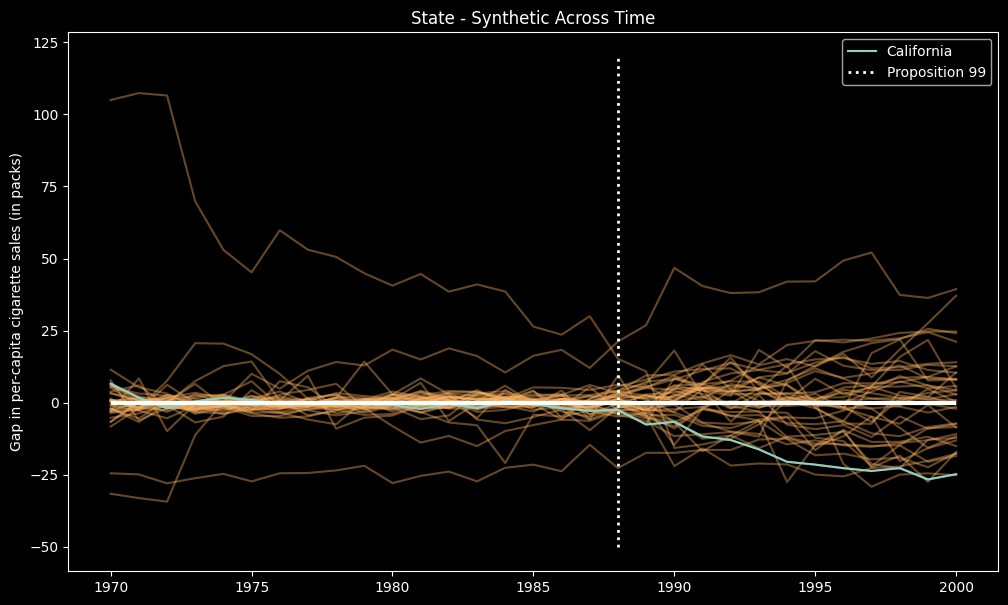

In [36]:
plt.figure(figsize=(12,7))
for state in synthetic_states:
    plt.plot(state["year"], state["cigsale"] - state["synthetic"], color="C5",alpha=0.4)

plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"] - calif_synth,
        label="California");

plt.vlines(x=1988, ymin=-50, ymax=120, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=3)
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.title("State - Synthetic Across Time")
plt.legend();

- pre intervention high variance = bad fit on convex combinations. these should be dropped from analysis based on mse of fit

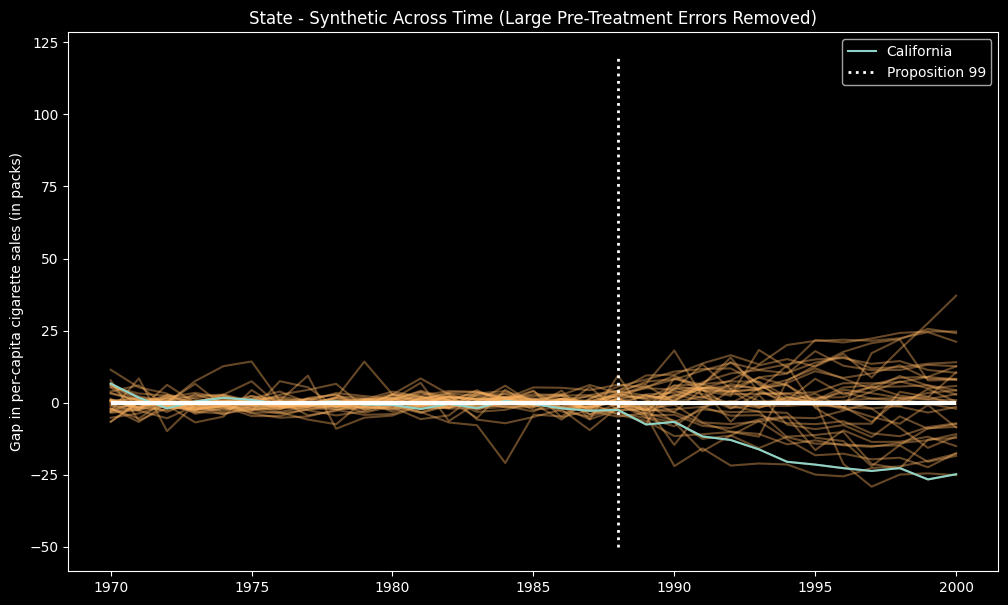

In [37]:
def pre_treatment_error(state):
    pre_treat_error = (state.query("~after_treatment")["cigsale"] 
                       - state.query("~after_treatment")["synthetic"]) ** 2
    return pre_treat_error.mean()

plt.figure(figsize=(12,7))
for state in synthetic_states:
    
    # remove units with mean error above 80.
    if pre_treatment_error(state) < 80:
        plt.plot(state["year"], state["cigsale"] - state["synthetic"], color="C5",alpha=0.4)

plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"] - calif_synth,
        label="California");

plt.vlines(x=1988, ymin=-50, ymax=120, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=3)
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.title("Distribution of Effects")
plt.title("State - Synthetic Across Time (Large Pre-Treatment Errors Removed)")
plt.legend();

Can immediately see that california is much more extreme, implying statistical significance. We can calculate a pvalue like so:
- find number of times effects are lower than that of california

In [38]:
calif_number = 3

effects = [state.query("year==2000").iloc[0]["cigsale"] - state.query("year==2000").iloc[0]["synthetic"]
           for state in synthetic_states
           if pre_treatment_error(state) < 80] # filter out noise

calif_effect = cigar.query("california & year==2000").iloc[0]["cigsale"] - calif_synth[-1] 

print("California Treatment Effect for the Year 2000:", calif_effect)
np.array(effects)

California Treatment Effect for the Year 2000: -24.83015973934797


array([  5.79715892,   0.89458999, -24.83015974,  -7.16628123,
       -10.92204857,  37.11640559, -15.0697171 ,  -0.49805129,
       -18.45795098,  21.13366459,  12.57782779,  -1.47547824,
        10.4962737 , -11.67012358,   4.29850815,   8.04811409,
        14.02322419,   8.25002763,   0.32576355,  -8.40826871,
        -2.12402704,  -7.42865045,   2.96157488,  24.10478105,
         4.2521177 , -17.75844576,   7.93334015,   2.81640134,
        12.64955967, -17.47677514, -25.16040932, -12.26469126,
        24.6906737 ,  10.36299588,  -8.59880335])

In [39]:
np.mean(np.array(effects) < calif_effect)

0.02857142857142857

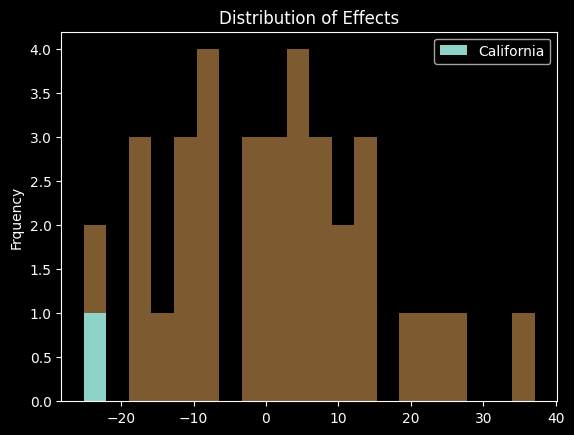

In [40]:
_, bins, _ = plt.hist(effects, bins=20, color="C5", alpha=0.5);
plt.hist([calif_effect], bins=bins, color="C0", label="California")
plt.ylabel("Frquency")
plt.title("Distribution of Effects")
plt.legend();